In [2]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

loss        46069
val_loss    31537
dtype: int64
min loss epoch set:  77
min val_loss epoch set:  5


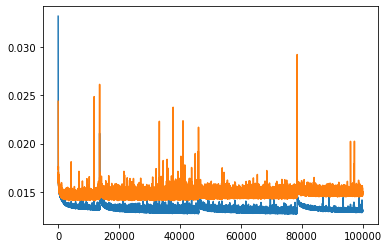

In [3]:
# find the model with lowest loss

# plot the losses from training history
training_history_0 = pd.read_pickle("history_0")

for rounds in range (1, 100):
    training_history_1 = pd.read_pickle("history_" + str(rounds))
    frames = [training_history_0, training_history_1]
    training_history_0 = pd.concat (frames, axis=0, ignore_index=True)

plt.plot (training_history_0)
#plt.savefig("cutoff0.002_training_history.png", dpi=300)

print (training_history_0.idxmin())

# determine epoch set with lowest loss
training_history_0 = pd.read_pickle("history_0")
loss = training_history_0[["loss"]]
meanloss0 = loss.mean()

for rounds in range (1, 100):
    training_history_1 = pd.read_pickle("history_" + str(rounds))
    loss = training_history_1[["loss"]]
    meanloss1 = loss.mean()
    frames = [meanloss0, meanloss1]
    meanloss0 = pd.concat (frames, axis=0, ignore_index=True)

print ("min loss epoch set: ", meanloss0.idxmin())

training_history_0 = pd.read_pickle("history_0")
val_loss = training_history_0[["val_loss"]]
meanloss0 = val_loss.mean()

for rounds in range (1, 100):
    training_history_1 = pd.read_pickle("history_" + str(rounds))
    val_loss = training_history_1[["val_loss"]]
    meanloss1 = val_loss.mean()
    frames = [meanloss0, meanloss1]
    meanloss0 = pd.concat (frames, axis=0, ignore_index=True)

print ("min val_loss epoch set: ", meanloss0.idxmin())

In [4]:
import os
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.layers import LeakyReLU

2022-08-15 03:21:13.401783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 03:21:13.401815: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# load saved model

from tensorflow import keras
epset = input('Epoch set No:')
autoencoder = keras.models.load_model('models/saved_model_'+ str(epset))

Epoch set No:99


2022-08-15 03:21:35.315979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-15 03:21:35.316031: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-15 03:21:35.316062: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (huantong-VirtualBox): /proc/driver/nvidia/version does not exist
2022-08-15 03:21:35.317815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def unison_shuffled_copies(a, b):
    # https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    # mix two arrays randomly in parallel
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [7]:
# load original datasets

wildtype_data = np.loadtxt ("thresh0.001_enriched_2-20aa_angle_result.txt") # read in wildtype lcc data
#wildtype_data = wildtype_data [:,1:] # delete first column which is frame number
wildtype_label = np.zeros(len(wildtype_data)) # set wildtype labels to 0 

mutant_1_data = np.loadtxt ("thresh0.001_enriched_2-20aa_angle_result_D132H.txt") # read in mutant lcc data
#mutant_1_data = mutant_1_data [:,1:] # delete first column which is frame number
mutant_1_label = np.ones(len(mutant_1_data)) # set mutant labels to 1

print('Wildtype Training Data Shape:', wildtype_data.shape)
print('Wildtype Label Data Shape:   ', wildtype_label.shape)
print('D132-H   Training Data Shape:', mutant_1_data.shape)
print('D132-H   Label Data Shape:   ', mutant_1_label.shape)

Wildtype Training Data Shape: (40000, 191)
Wildtype Label Data Shape:    (40000,)
D132-H   Training Data Shape: (40000, 191)
D132-H   Label Data Shape:    (40000,)


In [8]:
# generate combined and shuffled input data file
lcc_data = np.vstack((wildtype_data, mutant_1_data))
print ("Combined input_data.shape:", lcc_data.shape)

label_data = np.hstack((wildtype_label, mutant_1_label))
print ("Combined label_data.shape:", label_data.shape, "\n")

# here we shuffle both tensors simultaneously to maintain the labels with each data set
lcc_data, label_data = unison_shuffled_copies (lcc_data, label_data)

# normalize data
lcc_data = lcc_data/180

Combined input_data.shape: (80000, 191)
Combined label_data.shape: (80000,) 



In [ ]:
# project original dataset into trained model

# read in latent layer
dr_model = tf.keras.models.Model(inputs  = autoencoder.get_layer('e1').input, 
                                 outputs = autoencoder.get_layer('ae_latent').output)
dr_model.summary()

# put original dataset into latent model and save
x = []
y = []
z = []
for i in range(80000):
    z.append(label_data[i])
    op = dr_model.predict(np.array([lcc_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])
    #print(i)

df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["trajectory-" + str(k) for k in z]

file_name = 'cutoff0.001_latent_epochset_' + str(epset)
df.to_pickle(file_name)
print('saved')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 191)]             0         
                                                                 
 e1 (Dense)                  (None, 256)               49152     
                                                                 
 e2 (Dense)                  (None, 64)                16448     
                                                                 
 ae_latent (Dense)           (None, 2)                 130       
                                                                 
Total params: 65,730
Trainable params: 65,730
Non-trainable params: 0
_________________________________________________________________


In [28]:
# plot the latent data projection

plt.figure(figsize = (8, 6));
fig = sns.scatterplot(x = 'x', y='y', hue='z', data=df, s=1)
file_name = "cutoff0.001_latent_epochset_" + str(epset) + ".png"
fig.figure.savefig(file_name, dpi = 300)
#plt.clf()
plt.show()

0     0.014717
1     0.014085
2     0.014010
3     0.013992
4     0.013980
        ...   
95    0.013953
96    0.013960
97    0.013960
98    0.013959
99    0.013955
Length: 100, dtype: float64

In [ ]:
# hdbscan clustering

latent_df = pd.read_pickle('cutoff0.002_latent_epochset_14')
latent_df = latent_df.replace({'trajectory-0.0': 0, 'trajectory-1.0': 1})
latent_df = latent_df.drop('z', axis = 1)

clusterer = hdbscan.HDBSCAN(min_cluster_size=100).fit(latent_df)
color_palette = sns.color_palette('deep', 100)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
#cluster_member_sizes = np.ones(len(cluster_member_colors))
#plt.scatter(*latent_df.T, s=cluster_member_sizes, c=cluster_member_colors, alpha=0.25, linewidth=0)

fig = sns.scatterplot(x = 'x', y='y', data=latent_df, s=1, c=cluster_member_colors)
file_name = "cutoff0.002_latent_epochset_" + str(epset) + "_clustered.png"
fig.figure.savefig(file_name, dpi = 300)
plt.show()

In [ ]:
clusterer.labels_.max()